# at_mono package tree analysis

## Imports

In [24]:
from IPython.display import Image, display, SVG
from re import sub
from subprocess import Popen, PIPE
from pydot import graph_from_dot_data
import json
import pandas as pd

## Loading the data from melos

In [25]:
def melos_ls(args:list, ignore_example=True):
  if ignore_example:
    args += ['--ignore=*example*']
  process = Popen(['dart', 'pub', 'global', 'run', 'melos', 'ls', '-r'] + args, cwd='../', stdout=PIPE, stderr=PIPE)
  output, error = process.communicate()
  return output.decode('utf-8'), process.returncode == 0


In [26]:
# JSON format
JT, JTsuccess = melos_ls(['--json', '-l'])
JT = json.loads(JT)
print(f'Success: {JTsuccess}')

Success: True


In [27]:
# JSON relational graph format
GT, GTsuccess = melos_ls(['--graph'])
GT = json.loads(GT)
print(f'Success: {GTsuccess}')

Success: True


In [28]:
# Graphviz format
GV, GVsuccess = melos_ls(['--gviz'])

# For some reason, melos outputs ";" inside the "[]"
# instead of "," so we reformat with regex:
GV = sub(r'(\[.*)(\;)(.*\])', r'\1,\3', GV)

# Ensure that the subprocess was successful
print(f'Success: {GVsuccess}')

Success: True


## Plotting the data

### By module

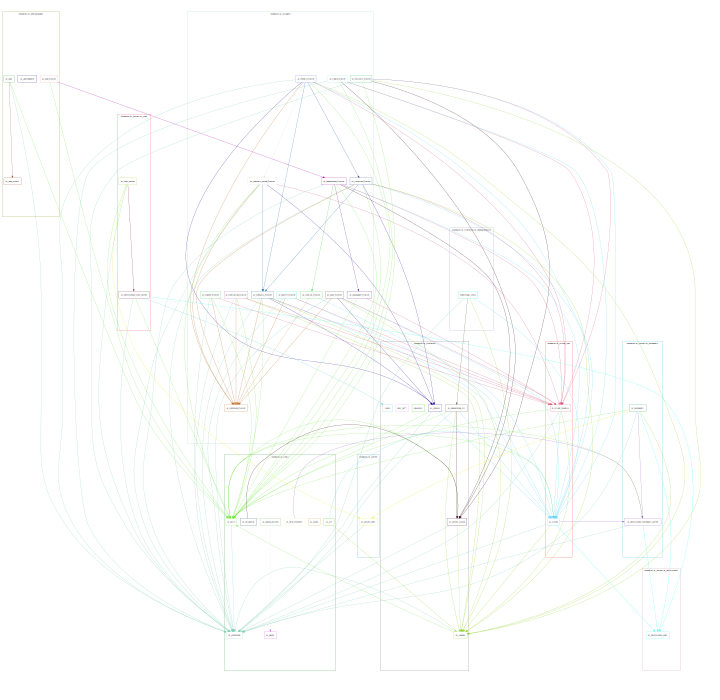

In [29]:
# Plot the Graphviz format
graphs = graph_from_dot_data(GV)
plt = SVG(graphs[0].create(prog='dot', format='svg'))
display(plt)

### By hierarchy

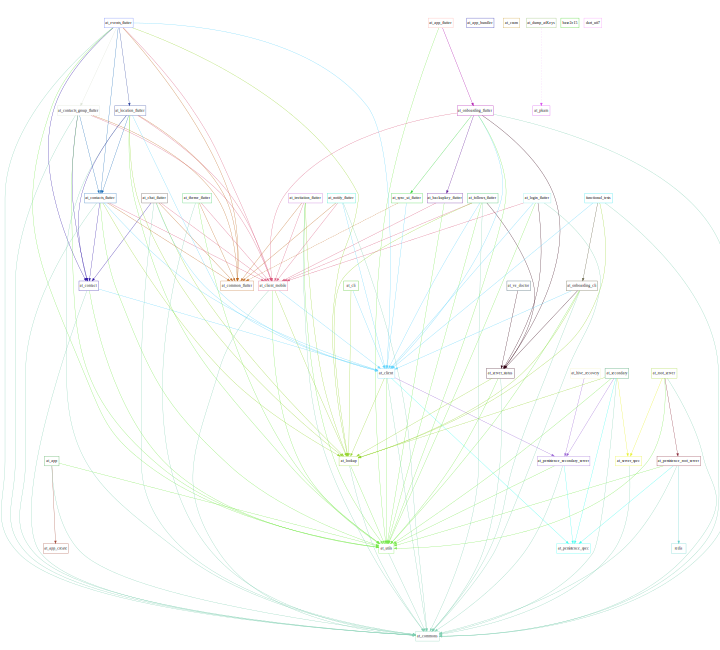

In [30]:
# Remove subgraphs (module groupings)
idx = GV.find('subgraph')
GVH = GV[:idx]
GVH += "}\n"

graphs = graph_from_dot_data(GVH)
plt = SVG(graphs[0].create(prog='dot', format='svg'))
display(plt)

## Specific Insights

### Generating Dependency Matrix

In [31]:
# Building a dependency matrix
#
# Follow the row to find packages that this 'record' depends on
# Thus if I want to find at_app's dependencies, I can look at the at_app row
# If I want to find packages that depend on at_commons, I can look at the at_commons column

df = pd.DataFrame(columns=(['name'] + list(GT.keys())))
for name in GT.keys():
  record = [ int(x in GT[name]) for x in GT.keys() ]
  record = [name] + record
  df.loc[len(df)] = record

# Drop columns with all 0's (i.e. the package is not depended on)
df.drop(columns=df.columns[df.sum()==0], inplace=True)

### Comparing dependency usage

#### at_utils, at_commons

In [32]:
selection = ["name", "at_utils", "at_commons"]

In [33]:
VC = df[selection].value_counts(selection[1:], normalize=True)
VC

at_utils  at_commons
1         1             0.476190
0         0             0.357143
          1             0.119048
1         0             0.047619
dtype: float64

In [34]:
T = VC[1,1] + VC[1,0] + VC[0,1]
T

0.6428571428571428

In [35]:
VC[1,1]/T

0.7407407407407408

#### at_utils, at_commons, at_common_flutter

In [36]:
selection = ["name", "at_utils", "at_commons", "at_common_flutter"]

In [37]:
df[selection].value_counts(selection[1:], normalize=True)

at_utils  at_commons  at_common_flutter
0         0           0                    0.333333
1         1           0                    0.333333
                      1                    0.142857
0         1           0                    0.071429
                      1                    0.047619
1         0           0                    0.047619
0         0           1                    0.023810
dtype: float64

#### at_utils, at_commons, at_onboarding_flutter

In [38]:
selection = ["name", "at_utils", "at_commons", "at_onboarding_flutter"]

In [39]:
df[selection].value_counts(selection[1:], normalize=True)

at_utils  at_commons  at_onboarding_flutter
1         1           0                        0.476190
0         0           0                        0.357143
          1           0                        0.119048
1         0           0                        0.023810
                      1                        0.023810
dtype: float64